In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["AUTOGRAPH_VERBOSITY"] = "10"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)

%system nvidia-smi
#%system rocm-smi

py 3.8.2
tf 2.2.0
keras 2.3.0-tf
mem 8051.83984375
cpu 6


['Wed Jul 01 00:55:42 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 451.48       Driver Version: 451.48       CUDA Version: 11.0     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0  On |                  N/A |',
 '|100%   40C    P8    18W / 120W |    671MiB /  6144MiB |     26%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                          

In [2]:
epochs = 100
batch_size = 32
testsplit = .15
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 120
seed = random.randint(1, 1000)

data_dir = "C:/Users/dedsec995/Projects/tensorflow/breed_dog_only/Data/dog/images/"
annotations_dir = "C:/Users/dedsec995/Projects/tensorflow/breed_dog_only/Data/dog/annotations/Annotation/"
cropped_dir = "C:/Users/dedsec995/Projects/tensorflow/breed_dog_only/notebook/data/"

In [3]:
%system rm -rf $cropped_dir
%system mkdir $cropped_dir

#this function adapted from https://www.kaggle.com/hengzheng/dog-breeds-classifier
def save_cropped_img(path, annotation, newpath):
    tree = ET.parse(annotation)
    xmin = int(tree.getroot().findall('.//xmin')[0].text)
    xmax = int(tree.getroot().findall('.//xmax')[0].text)
    ymin = int(tree.getroot().findall('.//ymin')[0].text)
    ymax = int(tree.getroot().findall('.//ymax')[0].text)
    image = Image.open(path)
    image = image.crop((xmin, ymin, xmax, ymax))
    image = image.convert('RGB')
    image.save(newpath)

def crop_images():
    breeds = os.listdir(data_dir)
    annotations = os.listdir(annotations_dir)

    print('breeds: ', len(breeds), 'annotations: ', len(annotations))

    total_images = 0

    for breed in breeds:
        dir_list = os.listdir(data_dir + breed)
        annotations_dir_list = os.listdir(annotations_dir + breed)
        img_list = [data_dir + breed + '/' + i for i in dir_list]
        os.makedirs(cropped_dir + breed)

        for file in img_list:
            annotation_path = annotations_dir + breed + '/' + os.path.basename(file[:-4])
            newpath = cropped_dir + breed + '/' + os.path.basename(file)
            save_cropped_img(file, annotation_path, newpath)
            total_images += 1
    
    print("total images cropped", total_images)

crop_images()

breeds:  120 annotations:  120
total images cropped 20580


In [3]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 17555 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


C:/Users/dedsec995/Projects/tensorflow/breed_dog_only/notebook/data/n02105056-groenendael\n02105056_3741.jpg


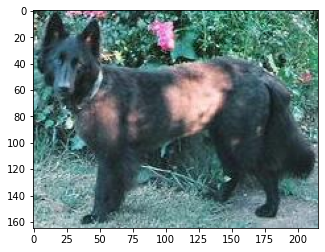

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('dog_breed_classifier.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             save_freq=1)

#https://github.com/keras-team/keras/issues/3358
tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
#                             batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [6]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(lr=learning_rate)
# optimizer = RMSprop(lr=learning_rate)

loss = "categorical_crossentropy"
# loss = "kullback_leibler_divergence"

for layer in model.layers:
    layer.trainable = True
# for layer in model.layers[-2:]:
#     layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

# model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 Conv1_pad True
2 Conv1 True
3 bn_Conv1 True
4 Conv1_relu True
5 expanded_conv_depthwise True
6 expanded_conv_depthwise_BN True
7 expanded_conv_depthwise_relu True
8 expanded_conv_project True
9 expanded_conv_project_BN True
10 block_1_expand True
11 block_1_expand_BN True
12 block_1_expand_relu True
13 block_1_pad True
14 block_1_depthwise True
15 block_1_depthwise_BN True
16 block_1_depthwise_relu True
17 block_1_project True
18 block_1_project_BN True
19 block_2_expand True
20 block_2_expand_BN True
21 block_2_expand_relu True
22 block_2_depthwise True
23 block_2_depthwise_BN True
24 block_2_depthwise_relu True
25 block_2_project True
26 block_2_project_BN True
27 block_2_add True
28 block_3_expand True
29 block_3_expand_BN True
30 block_3_expand_relu True
31 block_3_pad True
32 block_3_depthwise True
33 block_3_depthwise_BN True
34 block_3_depthwise_relu True
35 block_3_project True
36 block_3_project_BN True
37 block_4_expand True
38 block_4_expand_BN True
39 block

In [ ]:
%%time

params = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint]
                                verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Learning rate:  1e-04
Epoch 1/100
549/549 [==============================] - 327s 596ms/step - loss: 1.6202 - accuracy: 0.5883 - val_loss: 1.0959 - val_accuracy: 0.6747 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/100
549/549 [==============================] - 233s 424ms/step - loss: 0.7048 - accuracy: 0.7817 - val_loss: 0.9175 - val_accuracy: 0.7296 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 3/100
549/549 [==============================] - 237s 431ms/step - loss: 0.4897 - accuracy: 0.8489 - val_loss: 0.8242 - val_accuracy: 0.7501 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 4/100
549/549 [==============================] - 238s 434ms/step - loss: 0.3608 - accuracy: 0.8881 - val_loss: 0.8723 - val_accuracy: 0.7521 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 5/100
549/549 [==============================] - 239s 435ms/step - loss: 0.2725 - accuracy: 0.9172 - val_loss: 0.8675 - val_accuracy: 0.7574 - lr: 1.000

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Training and test accuracy')
plt.plot(params.epoch, params.history['accuracy'], label='Training accuracy')
plt.plot(params.epoch, params.history['val_accuracy'], label='Test accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and test loss')
plt.plot(params.epoch, params.history['loss'], label='Training loss')
plt.plot(params.epoch, params.history['val_loss'], label='Test loss')
plt.legend()

plt.show()

In [ ]:
# Randomly test an image from the test set

# model.load_weights('dog_breed_classifier.h5')

imageno=np.random.random_integers(low=0, high=test_generator.samples)

name = test_generator.filepaths[imageno]
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(test_generator.filepaths[imageno]).resize((targetx, targety))
print(img)
probabilities = model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

In [11]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.90      0.82      0.86        22
              n02085782-Japanese_spaniel       0.86      0.93      0.89        27
                   n02085936-Maltese_dog       0.78      0.95      0.85        37
                      n02086079-Pekinese       0.79      0.86      0.83        22
                      n02086240-Shih-Tzu       0.77      0.75      0.76        32
              n02086646-Blenheim_spaniel       1.00      0.79      0.88        28
                      n02086910-papillon       0.97      0.97      0.97        29
                   n02087046-toy_terrier       0.87      0.80      0.83        25
           n02087394-Rhodesian_ridgeback       0.76      0.64      0.70        25
                  n02088094-Afghan_hound       0.89      0.97      0.93        35
                        n02088238-basset       0.73      0.92      0.81    

Confusion Matrix


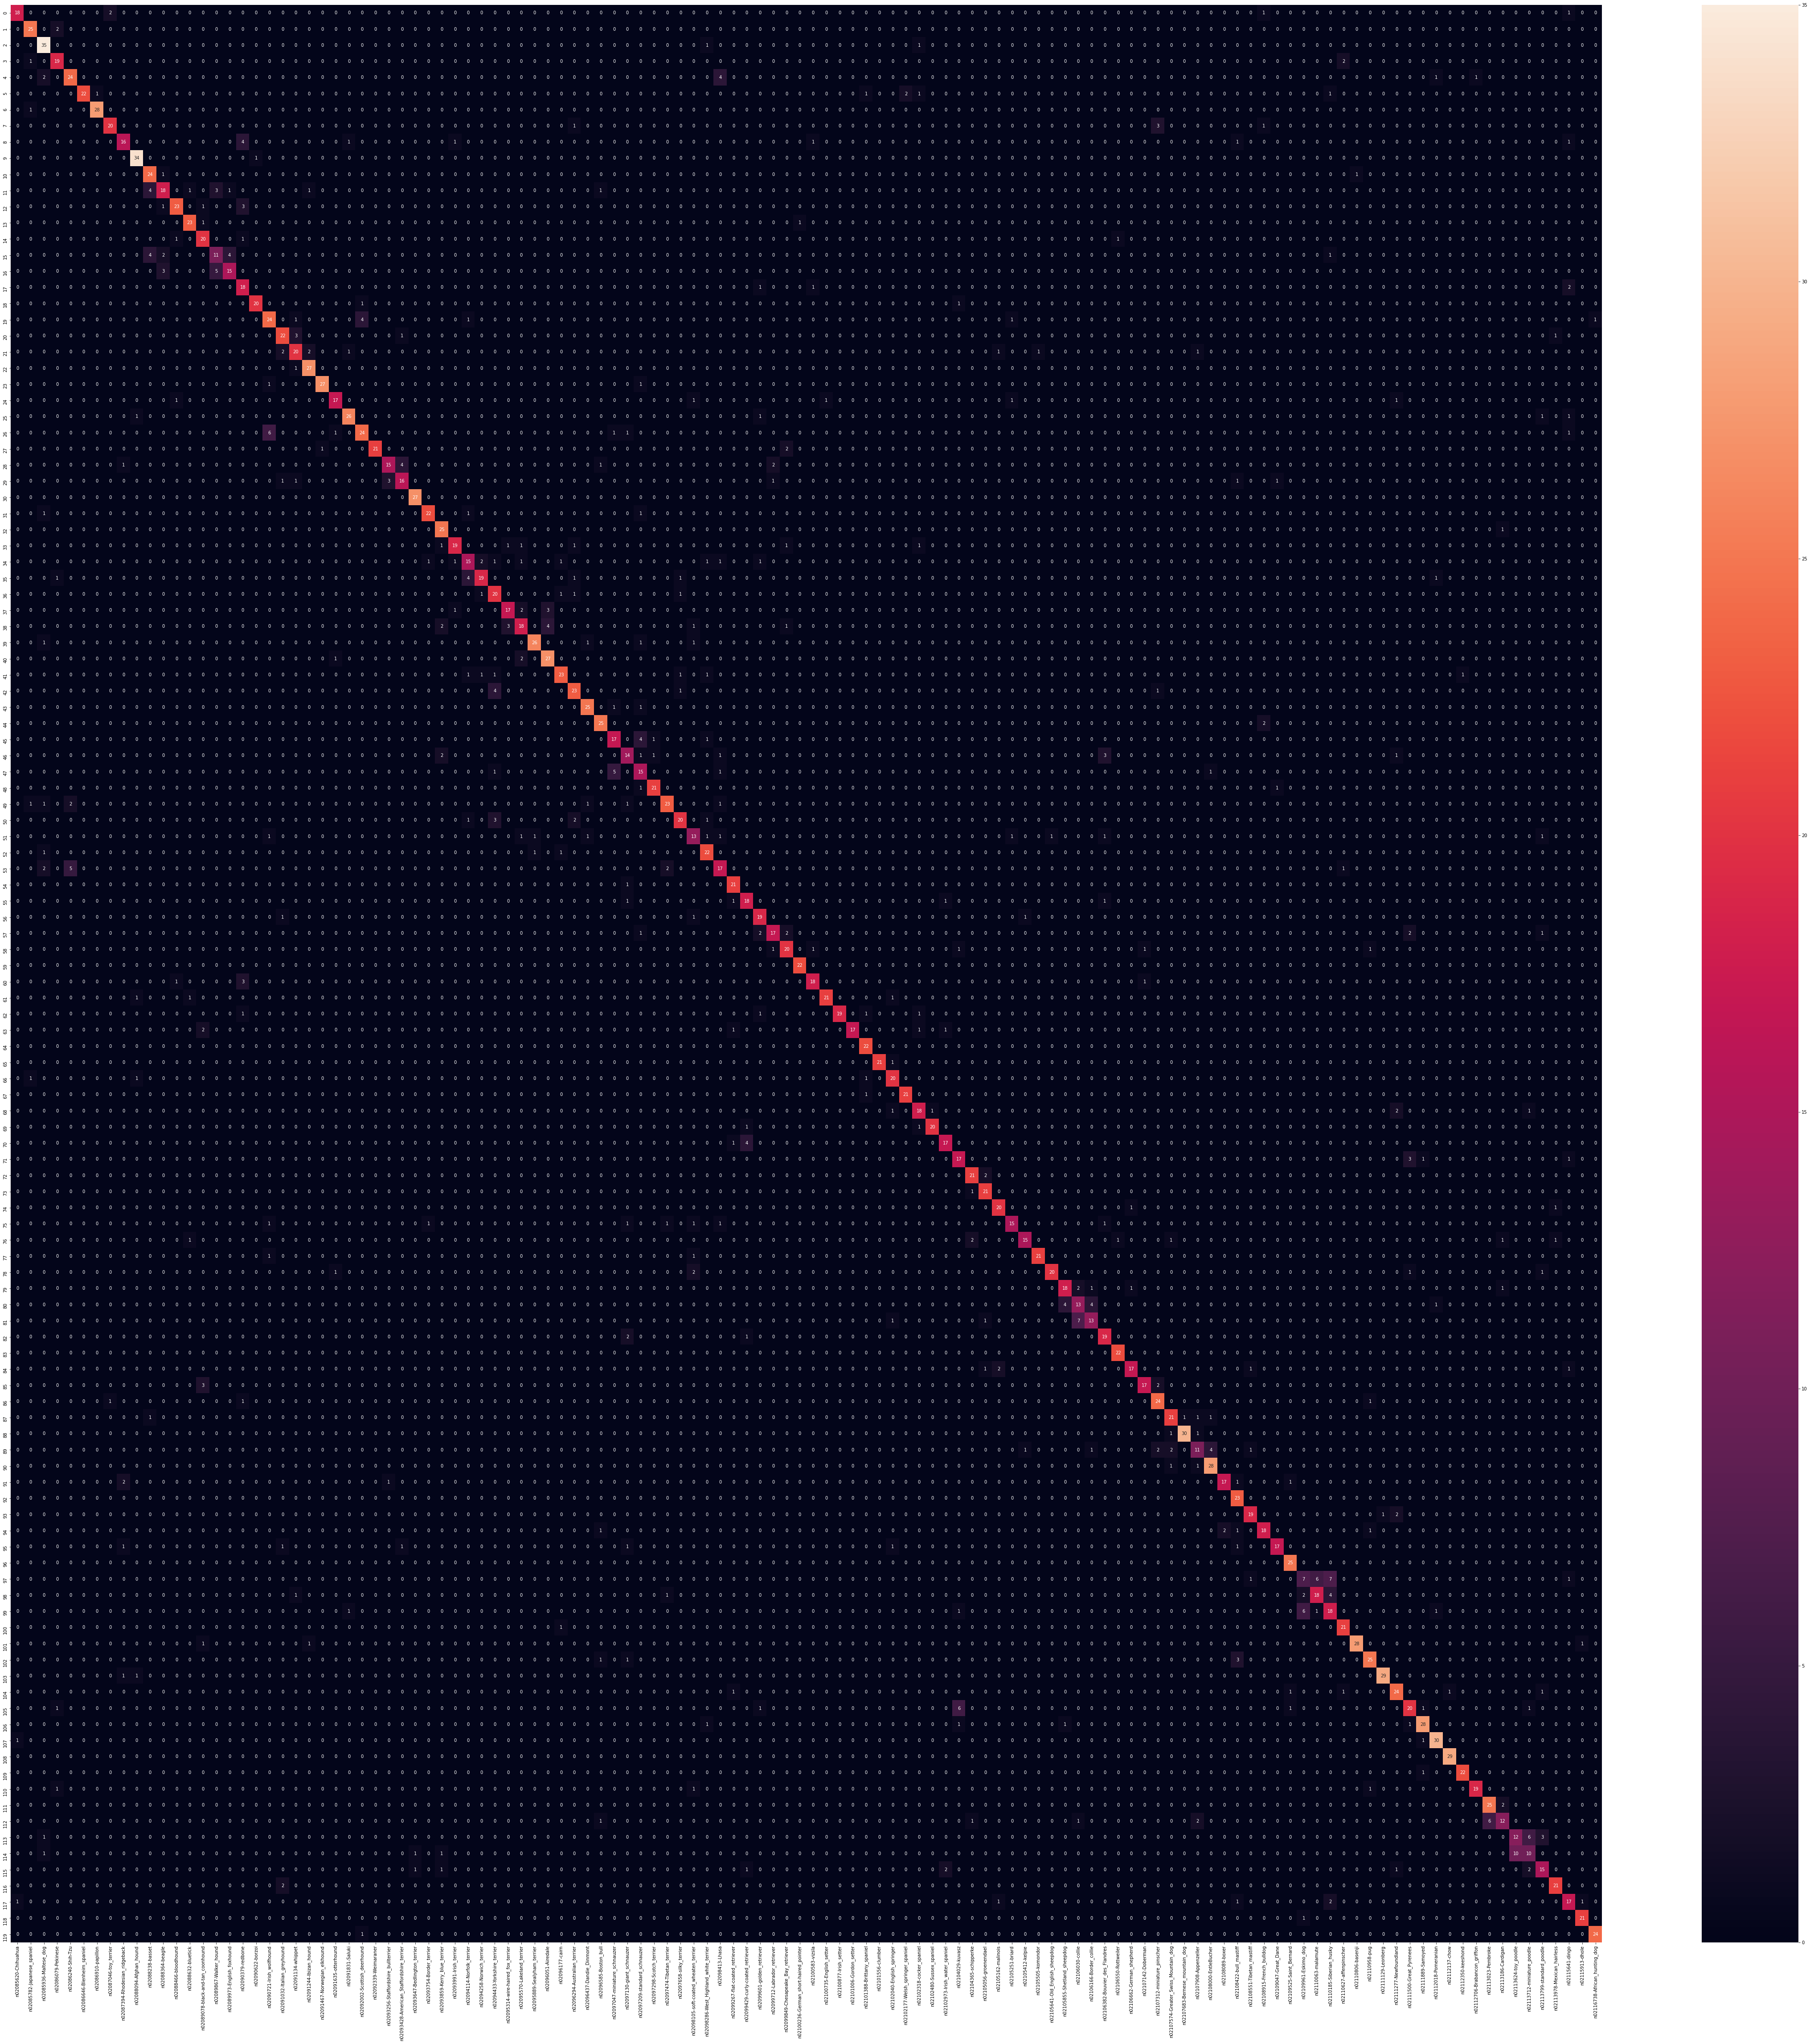

In [12]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y)
df = pd.DataFrame(cm, columns=test_generator.class_indices)
plt.figure(figsize=(80,80))
sn.heatmap(df, annot=True)

In [13]:
model.save('final')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


KeyboardInterrupt: 